In [9]:
import torch
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch import nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random

2.2.1+cu121


In [10]:
df = pd.read_csv('../fyp_data/smooth_df.csv')

date_column = 'Date'
date_number_column = 'Date Number'
ili_rate_column = 'ILI Rate'
query_columns = [col for col in df.columns if col not in [date_column, date_number_column, ili_rate_column]]

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [11]:
def custom_time_series_split(df, date_column):
    # Custom time series split based on years
    years = df[date_column].dt.year.unique()
    splits = [(years[5], years[i]) for i in range(10, len(years) - 4)]
    return splits

def get_train_test_split_data(X_shifted, y_shifted, X, y, train_start_date, test_start_date, test_end_date, corr_start_date):
    # Get the training and test data for a specific split
    train_indices = (X_shifted[date_column] >= train_start_date) & (X_shifted[date_column] < test_start_date)
    test_indices = (X_shifted[date_column] >= test_start_date) & (X_shifted[date_column] <= test_end_date)
    corr_indices = (X[date_column] >= corr_start_date) & (X[date_column] < test_start_date)

    X_train, y_train = X_shifted[train_indices], y_shifted[train_indices]
    X_test, y_test = X_shifted[test_indices], y_shifted[test_indices]
    X_corr, y_corr = X[corr_indices], y[corr_indices]

    return (X_train.iloc[:, 1:], y_train, X_test.iloc[:, 1:], y_test, X_corr.iloc[:, 1:], y_corr)

def min_max_data(X_train, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    return X_train_scaled, X_test_scaled

def create_lagged_features(df, n_lags):
    lagged_dfs = [df]
    for lag in range(1, n_lags + 1):
        lagged_df = df.shift(lag)
        lagged_df = lagged_df.add_suffix(f'_t-{lag}')
        lagged_dfs.append(lagged_df)

    all_lagged_df = pd.concat(lagged_dfs, axis=1)
    all_lagged_df = all_lagged_df.dropna()
    return all_lagged_df

def create_lagged_features_with_overlap(X_train, y_train, X_test, n_lags=13):
    X_train_lagged = create_lagged_features(X_train, n_lags)
    y_train = y_train.iloc[n_lags:]

    X_test = pd.concat([X_train.iloc[-n_lags:], X_test], ignore_index=True)
    X_test_lagged = create_lagged_features(X_test, n_lags)

    return X_train_lagged.values, y_train, X_test_lagged.values

def convert_to_tensor(X_train, y_train, X_test, y_test):
    return (
        torch.FloatTensor(X_train), torch.FloatTensor(y_train.values), torch.FloatTensor(X_test), torch.FloatTensor(y_test.values)
    )

In [12]:
def get_correlation_df(X_corr, y_corr):
    correlation_scores = []
    for query_column in X_corr.columns:
        correlation = y_corr.corr(X_corr[query_column])
        correlation_scores.append((query_column, correlation))
    return pd.DataFrame(correlation_scores, columns=['Query', 'Correlation'])

def correlation_based_feature_selection(X_corr, y_corr, X_train, X_test, threshold):
    correlation_df = get_correlation_df(X_corr, y_corr).sort_values(by='Correlation', ascending=False).reset_index(drop=True)
    relevant_queries = correlation_df[correlation_df['Correlation'] >= threshold]['Query'].to_list()

    X_train = X_train[relevant_queries]
    X_test = X_test[relevant_queries]

    print("number of features after correlation based fs: ", X_train.shape[1])
    print("X_train: ", X_train.shape, "X_test: ", X_test.shape)

    return X_train, X_test

In [13]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.fc2 = nn.Linear(4, 1)
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def create_ffnn(X_train, seed):
    torch.manual_seed(seed)
    return SimpleNN(X_train.shape[1]).to(device)

In [14]:
def train_neural_network(model, X_train, y_train, X_test, y_test, test_start_year, epochs=200, learning_rate=0.001, patience=15):
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=14, shuffle=False)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=14, shuffle=False)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))

        # Test phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(1)
                test_loss += criterion(outputs, targets).item()
            test_loss /= len(test_loader)
            test_losses.append(test_loss)

    # plt.figure(figsize=(10, 6))
    # plt.plot(train_losses, label='Training Loss')
    # plt.plot(test_losses, label='Test Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title(f'Training and Validation Losses {test_start_year}-{test_start_year+1}')
    # plt.legend()
    # plt.show()

    return (model, epoch+1, train_losses, test_losses)


def evaluate_neural_network(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        y_pred = model(X_test)


        y_pred_cpu = y_pred.cpu().detach().numpy().flatten()
        y_test_cpu = y_test.cpu().numpy().flatten()

        print("y_pred: ", y_pred_cpu[0:5])

        mae = mean_absolute_error(y_test_cpu, y_pred_cpu)
        mape = np.mean(np.abs((y_test_cpu - y_pred_cpu) / y_test_cpu)) * 100
        pearson_corr, _ = pearsonr(y_test_cpu, y_pred_cpu)
        print("MAE: ", mae, "MAPE: ", mape, "P: ", pearson_corr)

    return y_pred_cpu, mae, mape, pearson_corr

In [15]:
def add_average_row(model_performance):
    mae_avg = np.mean(model_performance['MAE'])
    pearson_corr_avg = np.mean(model_performance['Pearson_Correlation'])
    mape_avg = np.mean(model_performance['MAPE'])
    print("MAE AVG: ", mae_avg, "MAPE AVG: ", mape_avg, "P AVG: ", pearson_corr_avg, "\n\n")

    model_performance.loc[len(model_performance)] = {
        'Year': 'Average',
        'MAE': mae_avg,
        'MAPE': mape_avg,
        'Pearson_Correlation': pearson_corr_avg
    }

def run_neural_network(queries, threshold):
    X = df[[date_column] + queries]
    y = df[ili_rate_column]

    forecasting_horizon = 21
    y_shifted = y.shift(-forecasting_horizon)
    y_shifted = y_shifted.iloc[:-forecasting_horizon]
    X_shifted = X.iloc[:-forecasting_horizon]

    splits = custom_time_series_split(df, date_column)
    
    seed_train_losses = {}
    seed_test_losses = {}

    seed_performances = []
    seed_predictions = []

    seeds = [9904, 5727, 4644, 2955, 3021, 3094, 8349, 5566, 1564, 1723]

    for seed in seeds:
        print("SEED: ", seed)

        model_performance = pd.DataFrame(columns=['Year', 'MAE', 'MAPE', 'Pearson_Correlation'])
        model_predictions = pd.DataFrame(columns=['Date', 'Actual_ILI_Rate', 'Predicted_ILI_Rate'])

        for train_start_year, test_start_year in splits:
            if (test_start_year, test_start_year+1) not in seed_train_losses:
                seed_train_losses[(test_start_year, test_start_year+1)] = []
                seed_test_losses[(test_start_year, test_start_year+1)] = []

            train_start_date = f'{train_start_year}-09-01'
            test_start_date = f'{test_start_year}-09-01'
            test_end_date = f'{test_start_year+1}-08-31'
            corr_start_date = f'{test_start_year-5}-09-01'

            print("train_start_date: ", train_start_date, "test_start_date: ", test_start_date, "test_end_date: ", test_end_date)

            X_train, y_train, X_test, y_test, X_corr, y_corr = get_train_test_split_data(X_shifted, y_shifted, X, y, train_start_date, test_start_date, test_end_date, corr_start_date)
            X_train, X_test = correlation_based_feature_selection(X_corr, y_corr, X_train, X_test, threshold)
            X_train, X_test = min_max_data(X_train, X_test)
            # X_train, y_train, X_test = create_lagged_features_with_overlap(X_train, y_train, X_test)
            X_train, y_train, X_test, y_test = convert_to_tensor(X_train.values, y_train, X_test.values, y_test)

            model, epochs, train_losses, test_losses = train_neural_network(create_ffnn(X_train, seed), X_train, y_train, X_test, y_test, test_start_year)
            seed_train_losses[(test_start_year, test_start_year+1)].append(train_losses)
            seed_test_losses[(test_start_year, test_start_year+1)].append(test_losses)
            y_pred, mae, mape, pearson_corr = evaluate_neural_network(model, X_test, y_test)

            model_performance.loc[len(model_performance)] = {
                'Year': f'{test_start_year}-{test_start_year+1}',
                'MAE': mae,
                'MAPE': mape,
                'Pearson_Correlation': pearson_corr,
            }

            date_range = pd.date_range(start=f'{test_start_year}-09-{forecasting_horizon+1}', periods=len(y_pred))
            iteration_predictions = pd.DataFrame({
                'Date': date_range,
                'Predicted_ILI_Rate': y_pred,
                'Actual_ILI_Rate': y_test.cpu().numpy().flatten()
            })
            model_predictions = pd.concat([model_predictions, iteration_predictions])

        add_average_row(model_performance)

        seed_performances.append(model_performance)
        seed_predictions.append(model_predictions)

    avg_performance = pd.concat(seed_performances).groupby(['Year']).agg({'MAE': ['mean', 'std'], 'Pearson_Correlation': ['mean', 'std'], 'MAPE': ['mean', 'std']}).reset_index().round(5)
    avg_predictions = pd.concat(seed_predictions).groupby(['Date']).mean().reset_index()

    for test_start_year, test_end_year in seed_train_losses.keys():
        mean_train_losses = np.mean(np.array(seed_train_losses[(test_start_year, test_end_year)]), axis=0)
        mean_test_losses = np.mean(np.array(seed_test_losses[(test_start_year, test_end_year)]), axis=0)

        plt.figure(figsize=(10, 6))
        plt.plot(mean_train_losses, label='Training Loss')
        plt.plot(mean_test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Losses {test_start_year}-{test_start_year+1}')
        plt.legend()
        plt.show()

    return avg_performance, avg_predictions

SEED:  9904
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.7795823 3.6065917 2.002561  3.2340443 3.3709984]
MAE:  2.0223489 MAPE:  27.16343402862549 P:  0.8559150409425702
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.806295  3.0265532 3.3846393 3.4262342 3.191155 ]
MAE:  2.2504277 MAPE:  24.09028857946396 P:  0.8985828036932333
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.1160123 2.8245032 2.851462  2.4179    2.8476906]
MAE:  3.1810164 MAPE:  67.63044595718384 P:  0.8519597163301194
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.5448457 2.4943738 3.6727138 3.8531713 3.7621965]
MAE:  3.6303422 MAPE:  33.73468816280365 P:  0.8724039591725931
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.3234367 1.7455915 3.3741014 3.7252822 3.4464796]
MAE:  3.2367883 MAPE:  94.43561434745789 P:  0.8358825384303782
MAE AVG:  2.8641846 MAPE AVG:  49.410894215106964 P AVG:  0.8629488117137788 


SEED:  5727
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.7567923 3.5862002 1.9904994 3.2250764 3.4037156]
MAE:  2.0070567 MAPE:  26.85506045818329 P:  0.8577952295390434
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.4657829 2.5164208 2.8383996 2.996703  2.6293547]
MAE:  2.2753706 MAPE:  23.13898205757141 P:  0.9059927341983381
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.091177  2.8324766 2.962668  2.4442363 2.9709601]
MAE:  3.1970096 MAPE:  67.36669540405273 P:  0.8386569249564487
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.3578007 2.4937174 2.9219368 3.3164544 3.036439 ]
MAE:  3.2828493 MAPE:  27.17125415802002 P:  0.8861596411146841
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [5.209719 5.209719 5.209719 5.209719 5.209719]
MAE:  4.4053955 MAPE:  108.28931331634521 P:  nan
MAE AVG:  3.0335364 MAPE AVG:  50.564261078834534 P AVG:  0.8721511324521286 


SEED:  4644
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)


/tmp/ipykernel_3175842/3281515322.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(y_test_cpu, y_pred_cpu)


y_pred:  [2.8998427 3.60992   2.3627381 3.1407175 3.1879754]
MAE:  2.0223117 MAPE:  25.789958238601685 P:  0.8456507320343182
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.568682  2.6243558 2.9579842 2.9612849 2.7951114]
MAE:  2.2729623 MAPE:  23.132945597171783 P:  0.9072070335996634
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.0008454 2.6139917 3.0936413 2.7293892 3.294077 ]
MAE:  3.3241131 MAPE:  68.29911470413208 P:  0.821073401653493
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.217089  2.4796472 3.155975  3.4999254 3.23875  ]
MAE:  3.4174914 MAPE:  27.96442210674286 P:  0.8706291117609302
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.5339365 2.1616244 2.8916848 3.1159708 2.9454029]
MAE:  2.3381777 MAPE:  50.85785984992981 P:  0.8929291037312359
MAE AVG:  2.6750112 MAPE AVG:  39.20886009931564 P AVG:  0.8674978765559281 


SEED:  2955
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [3.0380063 3.6547916 2.2258077 3.2855563 3.603554 ]
MAE:  1.9691155 MAPE:  26.468166708946228 P:  0.856541314702358
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.2722106 2.271573  2.7950015 2.857258  2.688544 ]
MAE:  2.3411314 MAPE:  27.184852957725525 P:  0.8971137879578733
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.0193892 2.7699208 3.006546  2.4884586 2.973793 ]
MAE:  3.1939778 MAPE:  66.72025322914124 P:  0.8371536697415859
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.2076206 2.445325  3.0477867 3.5369887 3.1218276]
MAE:  3.385075 MAPE:  28.287023305892944 P:  0.8827154906888778
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.7184653 2.4104936 2.8757753 3.0133882 3.0015323]
MAE:  2.142909 MAPE:  45.55006921291351 P:  0.895136202995079
MAE AVG:  2.6064417 MAPE AVG:  38.84207308292389 P AVG:  0.8737320932171547 


SEED:  3021
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.7760072 3.6029046 2.2702262 3.1107924 3.141718 ]
MAE:  2.032208 MAPE:  25.813165307044983 P:  0.8477815953788812
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.7411823 3.1393523 3.570335  3.5573223 3.248327 ]
MAE:  2.2303302 MAPE:  22.15242236852646 P:  0.8973272596948019
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.5112922 3.2728841 3.1165938 1.9246676 3.0242832]
MAE:  3.101808 MAPE:  74.53578114509583 P:  0.8522065271488397
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.1811564 2.3990428 2.9996324 3.4302745 3.1876495]
MAE:  3.3862054 MAPE:  27.325481176376343 P:  0.8738425849367308
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.6274369 2.3160596 2.7427394 2.9827602 3.1672482]
MAE:  2.070911 MAPE:  45.73878049850464 P:  0.8818491772016622
MAE AVG:  2.5642924 MAPE AVG:  39.11312609910965 P AVG:  0.8706014288721832 


SEED:  3094
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.6566377 3.7161524 1.9184299 3.2463331 3.3276656]
MAE:  2.0647469 MAPE:  28.453844785690308 P:  0.8538311105666374
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.918923  3.0409436 3.5700703 3.8316522 3.2016335]
MAE:  2.2951484 MAPE:  27.81134843826294 P:  0.8819879963311757
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.4600224 3.3185368 3.0941753 1.8453232 2.9057195]
MAE:  3.0787628 MAPE:  74.37397837638855 P:  0.8513471889068694
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.0686738 2.3891506 3.202923  3.5018263 3.2770872]
MAE:  3.5010366 MAPE:  29.063695669174194 P:  0.8684848816544443
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.0848978 1.7620621 2.8079817 3.6011953 3.5630596]
MAE:  2.757791 MAPE:  72.45985865592957 P:  0.8481303869003846
MAE AVG:  2.739497 MAPE AVG:  46.43254518508911 P AVG:  0.8607563128719022 


SEED:  8349
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.6455228 3.9590664 2.0130012 3.3336651 3.4054656]
MAE:  2.1603506 MAPE:  29.96024787425995 P:  0.8433220590894289
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.8642826 3.413929  3.793479  3.7326274 3.4634833]
MAE:  2.2391777 MAPE:  24.550290405750275 P:  0.8898344846355731
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.4472144 3.41167   3.1416616 1.8867408 2.8502154]
MAE:  3.1082284 MAPE:  75.08119344711304 P:  0.8527382061680226
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.5586634 2.477716  3.7176044 3.8921769 3.7954745]
MAE:  3.6892562 MAPE:  37.33685612678528 P:  0.8740074749551748
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.4394083 2.2093377 2.619922  2.8992858 2.5843825]
MAE:  2.1152287 MAPE:  43.02029013633728 P:  0.8949874810663575
MAE AVG:  2.6624484 MAPE AVG:  41.989775598049164 P AVG:  0.8709779411829114 


SEED:  5566
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [3.0153904 3.6377823 2.1900167 3.2422142 3.5775893]
MAE:  1.9754231 MAPE:  26.522597670555115 P:  0.8570243058794332
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.2979865 2.3375928 2.8079455 2.8737977 2.7008271]
MAE:  2.3399055 MAPE:  27.10779309272766 P:  0.8972470990576559
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.0661173 2.5485473 3.055601  2.568918  3.1625564]
MAE:  3.1901448 MAPE:  64.34928178787231 P:  0.8188106214488633
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.0843253 2.4386165 3.2145085 3.5287251 3.31672  ]
MAE:  3.4886382 MAPE:  28.526240587234497 P:  0.8689946160225487
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.3672938 1.8386878 2.682075  3.5845375 3.5707936]
MAE:  2.584238 MAPE:  65.68560600280762 P:  0.8556119745591805
MAE AVG:  2.7156699 MAPE AVG:  42.43830382823944 P AVG:  0.8595377233935363 


SEED:  1564
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.6981816 3.6846983 1.9461696 3.2252324 3.3577578]
MAE:  2.0327492 MAPE:  28.089797496795654 P:  0.8546032242006575
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.8304765 2.8572109 3.3882992 3.5883725 3.0927765]
MAE:  2.3095334 MAPE:  27.359020709991455 P:  0.8850047935234215
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.096399  2.8337953 3.0289946 2.4402246 2.9854414]
MAE:  3.1428175 MAPE:  66.43423438072205 P:  0.8430843737644714
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.161371  2.2539303 2.9948804 3.282817  2.9863615]
MAE:  3.2897036 MAPE:  24.78567063808441 P:  0.8885100810137716
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.2887168 1.7790637 2.7213764 3.6061964 3.5754383]
MAE:  2.676337 MAPE:  69.45984363555908 P:  0.8527035189251865
MAE AVG:  2.690228 MAPE AVG:  43.22571337223053 P AVG:  0.8647811982855018 


SEED:  1723
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.7386103 3.5764954 1.9660841 3.1837795 3.3601174]
MAE:  2.0219793 MAPE:  27.192196249961853 P:  0.8571883136110103
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_3175842/4097294397.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.6416583 2.653073  3.1971765 3.3427703 3.0098653]
MAE:  2.3270934 MAPE:  27.242031693458557 P:  0.8883760018466523
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [3.5104027 3.2991757 3.0948906 1.9476299 3.020843 ]
MAE:  3.1497688 MAPE:  75.5207359790802 P:  0.8486777942344007
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.1862242 2.458329  3.1372855 3.5395427 3.2478473]
MAE:  3.449737 MAPE:  28.339111804962158 P:  0.8712202278390455
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.7071018 2.3513875 2.9792864 3.075663  3.0634437]
MAE:  2.2026076 MAPE:  49.136653542518616 P:  0.8936497541598861
MAE AVG:  2.630237 MAPE AVG:  41.48614585399628 P AVG:  0.871822418338199 




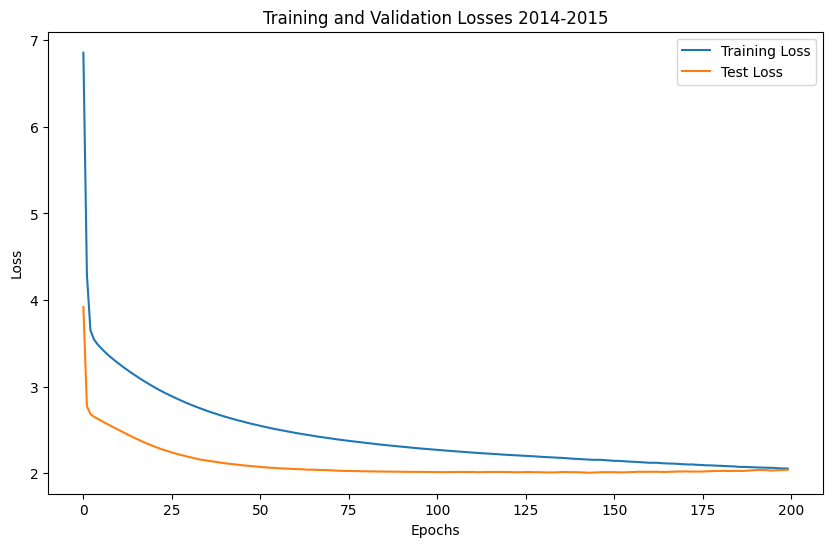

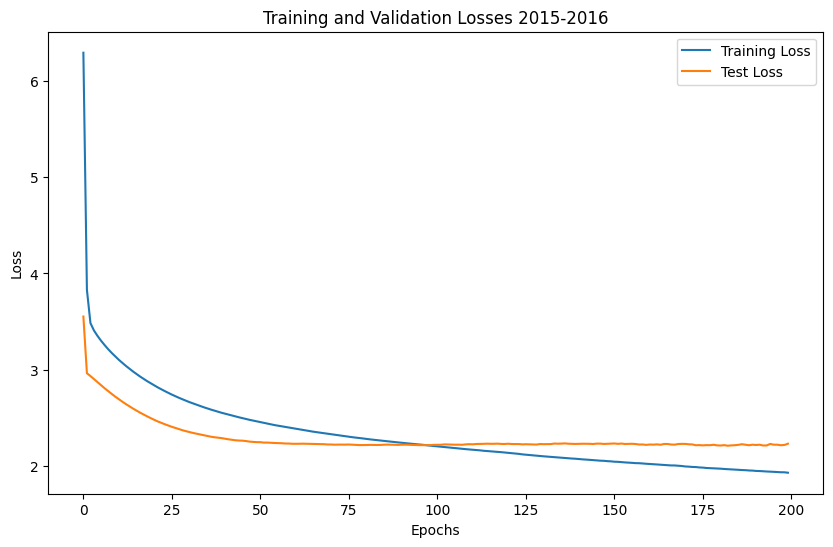

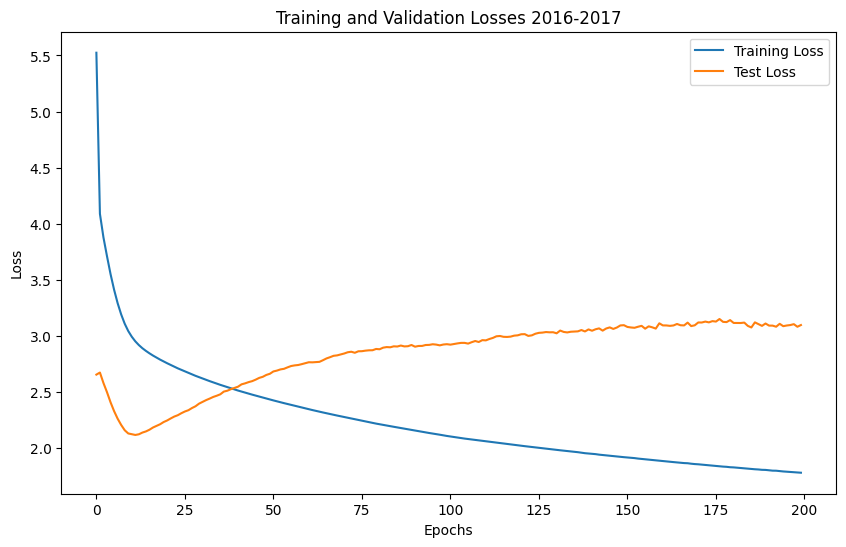

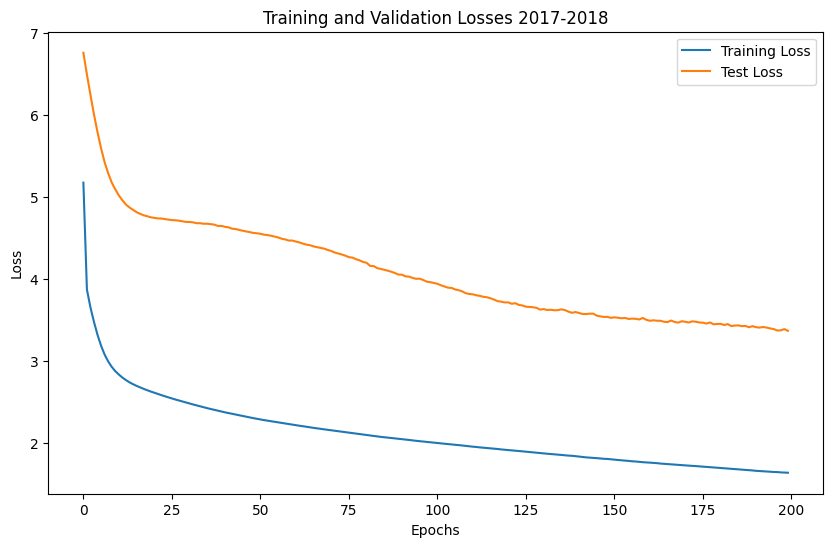

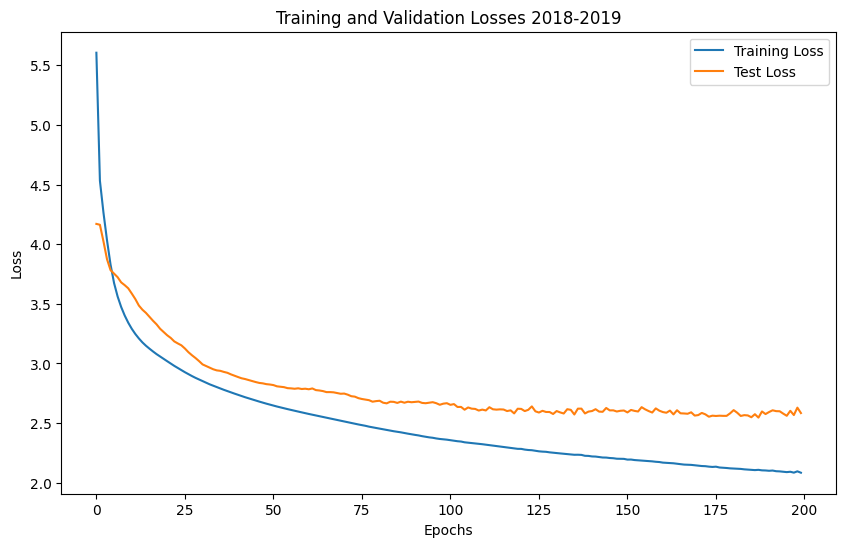

        Year      MAE          Pearson_Correlation               MAPE  \
                 mean      std                mean      std      mean   
0  2014-2015  2.03083  0.05333             0.85297  0.00533  27.23085   
1  2015-2016  2.28811  0.04092             0.89487  0.00841  25.37700   
2  2016-2017  3.16676  0.06946             0.84157  0.01274  70.03117   
3  2017-2018  3.45203  0.13199             0.87570  0.00732  29.25344   
4  2018-2019  2.65304  0.71633             0.87232  0.02393  64.46339   
5    Average  2.71815  0.13779             0.86748  0.00514  43.27117   

             
        std  
0   1.29098  
1   2.16995  
2   4.30551  
3   3.61222  
4  22.35471  
5   4.21390  


In [16]:
query_similarities = pd.read_csv('../fyp_data/average.csv').iloc[:1000]['Query'].to_list()
model_performance, model_predictions = run_neural_network(query_similarities, threshold=0.3)
model_performance.to_csv('../results/baseline_ffnn/forecasting_t+21_performance.csv', index=False)
model_predictions.to_csv('../results/baseline_ffnn/forecasting_t+21_predictions.csv', index=False)
print(model_performance)